In [5]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter, HourLocator
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from glob import glob
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")
from ipywidgets import interact, fixed

%matplotlib inline
plt.rcParams['font.sans-serif'] = ['SimHei']  # 解决中文显示问题
plt.rcParams['axes.unicode_minus'] = False    # 解决负号显示问题

In [3]:
files = glob("../datas/报警记录/*.csv")
dfs = []

for file in files:
    df = pd.read_csv(file, encoding='gbk')
    dfs.append(df)

warn_df = pd.concat(dfs, ignore_index=True)

In [14]:
warn_df

,开始时间,结束时间,报警代码,ErrorDetail,报警详情,报警分类,持续时间,工站,日期
0,2025-06-16 08:07:40,2025/6/16 8:07:40,F01ESSE-01-03,Emergency stop alarm,设备急停报警,Safety Error,0.21,S4,2025-06-16
1,2025-06-16 08:30:55,2025/6/16 8:30:56,N03IPPO-79-03,PC Communication Abnormality,上位机通讯异常,Software Error,1.28,S2,2025-06-16
2,2025-06-16 08:32:47,2025/6/16 8:33:01,V01VSDV-132-03,Popup:Platform1 CHG Assembly Top Photography F...,弹窗:组CHG上相机拍照失败1,Vision Error,14.00,S2,2025-06-16
3,2025-06-16 08:33:02,2025/6/16 8:34:11,V01VSDV-132-03,Popup:Platform1 CHG Assembly Top Photography F...,弹窗:组CHG上相机拍照失败1,Vision Error,69.13,S2,2025-06-16
4,2025-06-16 09:38:05,2025/6/16 9:38:06,M99EEDE-10-03,Platform 1X-axis alarm,平台1X轴报警,Motion Error,0.86,S4,2025-06-16
...,...,...,...,...,...,...,...,...,...
386,2025-06-28 16:16:53,2025/6/28 16:16:57,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,4.62,S2,2025-06-28
387,2025-06-28 16:23:12,2025/6/28 16:23:16,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,3.96,S2,2025-06-28
388,2025-06-28 16:23:16,2025/6/28 16:23:50,V01VSDV-131-03,Popup:Platform1 SPK Assembly Top Photography F...,弹窗:组SPK上相机拍照失败1,Vision Error,33.81,S2,2025-06-28
389,2025-06-28 16:27:32,2025/6/28 16:27:34,F01ESSE-01-03,Emergency Stop Alarm,设备急停报警,Safety Error,2.22,S2,2025-06-28


In [29]:
warn_df['开始时间'] = pd.to_datetime(warn_df['开始时间'])
warn_df['日期'] = warn_df['开始时间'].dt.date
warn_df.to_csv("../files/warnlog.csv", index=False)

In [ ]:

# 报警统计函数
def generate_alarm_stats(df: pd.DataFrame):
    # 按日期和报警分类统计
    alarm_stats = df.groupby(['日期', '报警分类']).agg(
        报警次数=('报警分类', 'count'),
        总持续时间=('持续时间', 'sum'),
        平均持续时间=('持续时间', 'mean'),
        最长持续时间=('持续时间', 'max')
    ).reset_index()
    
    # 计算报警总次数和总持续时间
    date_stats = df.groupby('日期').agg(
        总报警次数=('报警分类', 'count'),
        总持续时间=('持续时间', 'sum'),
        平均持续时间=('持续时间', 'mean')
    ).reset_index()
    
    # 按工站统计
    station_stats = df.groupby(['日期', '工站']).agg(
        工站报警次数=('报警分类', 'count'),
        工站持续时间=('持续时间', 'sum')
    ).reset_index()
    
    return alarm_stats, date_stats, station_stats

alarm_stats, date_stats, station_stats = generate_alarm_stats(warn_df)

In [22]:
# 整理日期列表（确保排序）
dates = sorted(df['日期'].unique())

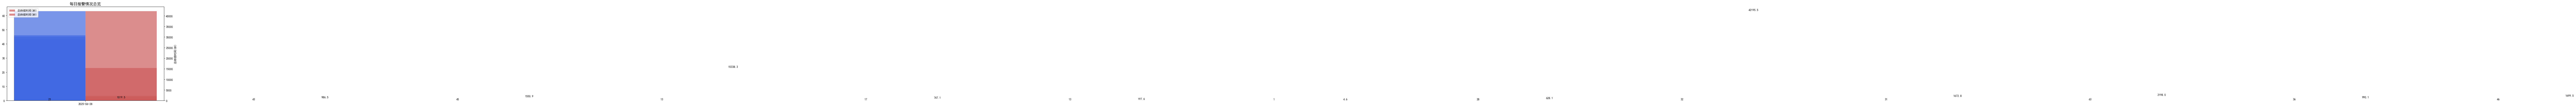

In [26]:
# 图表1: 每日报警总次数和总持续时间对比
plt.figure(figsize=(10, 6))
plt.title('每日报警情况总览', fontsize=14)
width = 0.35  # 柱状图宽度

# 设置位置索引
x = np.arange(len(dates))

# 左侧Y轴：报警次数
plt.bar(x - width/2, date_stats['总报警次数'], width, label='报警次数', color='royalblue', alpha=0.7)

# 右侧Y轴：持续时间
ax2 = plt.twinx()
plt.bar(x + width/2, date_stats['总持续时间'], width, label='总持续时间(秒)', color='indianred', alpha=0.7)

# 添加标签
for i, v in enumerate(date_stats['总报警次数']):
    plt.text(i - width/2, v + 1, f"{v}", ha='center', va='bottom')

for i, v in enumerate(date_stats['总持续时间']):
    ax2.text(i + width/2, v + 10, f"{v:.1f}", ha='center', va='bottom')

# 设置标签
plt.xticks(x, dates, rotation=45)
plt.xlabel('日期')
plt.ylabel('报警次数')
ax2.set_ylabel('总持续时间(秒)')

# 添加图例
lines, labels = plt.gca().get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
plt.legend(lines + lines2, labels + labels2, loc='best')

# plt.tight_layout()
# plt.savefig('Daily_Alarm_Overview.png', dpi=300)
plt.show()


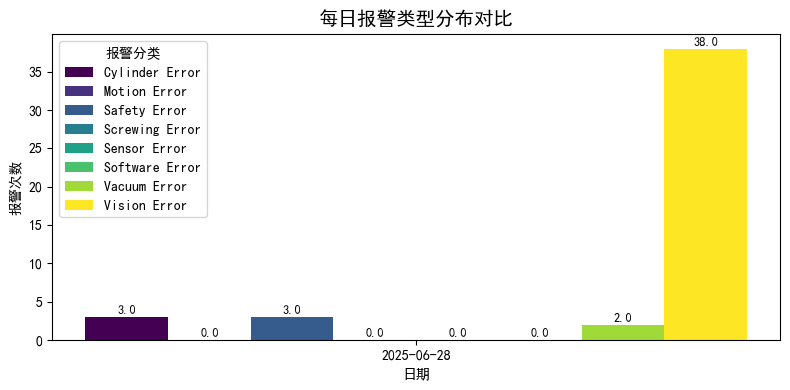

In [ ]:
# 图表2: 报警类型分布对比（每日）
plt.figure(figsize=(8, 4), dpi=100)
plt.title('每日报警类型分布对比', fontsize=14)

# 准备数据透视表
pivot_df = alarm_stats.pivot(index='日期', columns='报警分类', values='报警次数').fillna(0).loc[dates]

# 绘制分组柱状图
x = np.arange(len(dates))
width = 0.2  # 每组柱状图宽度

colors = plt.get_cmap('viridis')(np.linspace(0, 1, len(pivot_df.columns)))

for i, category in enumerate(pivot_df.columns):
    positions = x + i * width
    plt.bar(positions, pivot_df[category], width, label=category, color=colors[i])
    # 添加数据标签
    for j, value in enumerate(pivot_df[category]):
        plt.text(positions[j], value + 0.1, f"{value}", ha='center', va='bottom', fontsize=9)

plt.xticks(x + (len(pivot_df.columns)-1)/2 * width, dates)
plt.xlabel('日期')
plt.ylabel('报警次数')
plt.legend(title='报警分类')

plt.tight_layout()
# plt.savefig('Alarm_Type_Distribution.png', dpi=300)
plt.show()